#### Import libraries

In [4]:
# !pip install calval_data_access
# !pip install calval_etl


Looking in indexes: https://pypi.org/simple, http://pypi.arable.cloud:6543/simple
ERROR: Could not find a version that satisfies the requirement unify_data (from versions: none)
ERROR: No matching distribution found for unify_data


In [5]:
import datetime as dt
import sys
import os
import pathlib
import pathlib
import plotly.express as px
import pandas as pd
import plotly.graph_objects as go
path_to_calval_etl = '/home/ec2-user/SageMaker/calval-etl'
sys.path.append(path_to_calval_etl)
# from data_streams.api import zentra
# from utilities.secondary_processing import unify_data
# from mark_data_access import get_user_db_creds, query_constructor, get_db_data

from calval_data_access.mark_data import get_db_data, get_user_db_creds

In [6]:
import pandas as pd
import boto3
from botocore.session import Session

session = Session()
import json
import psycopg2 as pg
import pandas.io.sql as psql
import datetime as dt
import numpy as np



#### Load merged data ( df that have both reference and mark data)

There is a separate notebook for pulling and merging data
(https://github.com/Arable/water-stress/blob/main/UCD_Almond_mark_reference_data.ipynb)

In [7]:
merged_df = pd.read_csv('s3://arable-adse-dev/Carbon Project/Stress Index/UCD_Almond/merged_2021.csv')

In [8]:
# merged_df.columns

In [9]:
## check device and the corrresponding irrigation treatment label
merged_df.treatment.unique()

array(['ET100', 'ET75'], dtype=object)

In [10]:
## there are two IRT devices per treatment so average into one
merged_df['ref_tbelow'] = merged_df[['IR1_Avg', 'IR2_Avg']].mean(axis=1) 

#### Subset data based on treatments ( ET75 and ET100)

In [11]:
ET_100_df = merged_df[merged_df.treatment== 'ET100']
ET_75_df= merged_df[merged_df.treatment== 'ET75']

In [12]:
# ET_100_df.columns

#### Data visualisation (tbelow and NDVI) from each treatment dataframe 
1. ET100

In [13]:
df_ET_100_p = ET_100_df.copy() ## create a copy of df
## convert df into half hour
df_ET_100_p['local_time'] = df_ET_100_p['local_time'].astype('datetime64[ns]').dt.round('30min')

In [14]:
df_ET_100_p = ET_100_df.copy() ## create a copy of df
## Round datetime to 30 min frequencies
df_ET_100_p['local_time'] = df_ET_100_p['local_time'].astype('datetime64[ns]').dt.round('30min')


## convert some columns into numeric
cols= [i for i in df_ET_100_p.columns if i not in ['local_time','device','treatment', 'location', 'update_time', 'create_time']]
for col in cols:
    df_ET_100_p[col] = pd.to_numeric(df_ET_100_p[col], errors ='coerce')

## group by to  take average for each 30 min   
df_ET_100_p1 = df_ET_100_p.groupby('local_time').mean().reset_index()


In [15]:
df_ET_100_p1.head(5)

,local_time,time_x,b1dw,b1uw,b2dw,b2uw,b3dw,b3uw,b4dw,b4uw,...,Light_Ch0_Avg,Light_Ch1_Avg,ADC0_Avg,Sapflow(ml/hr),Sapflow(mm/day),Dt,Dr,Gt,Gc,ref_tbelow
0,2021-05-05 00:00:00,NaN,0.002886,0.003051,0.001546,0.001502,0.002522,0.002060,0.002308,0.002401,...,0.0,0.0,2.499,19.750000,0.025750,NaN,NaN,0.041000,0.040750,16.663750
1,2021-05-05 00:30:00,NaN,0.002955,0.002801,0.001476,0.001517,0.002516,0.001991,0.002216,0.002174,...,0.0,0.0,2.499,44.000000,0.056800,0.023333,0.046667,0.090200,0.090000,16.675000
2,2021-05-05 01:00:00,NaN,0.002902,0.002890,0.001498,0.001474,0.002318,0.002027,0.002456,0.002230,...,0.0,0.0,2.499,26.428571,0.033857,0.012857,0.031429,0.055286,0.055000,16.322857
3,2021-05-05 01:30:00,NaN,0.002832,0.002965,0.001512,0.001450,0.002528,0.002106,0.002254,0.002212,...,0.0,0.0,2.499,12.600000,0.016200,0.044000,0.098000,0.028600,0.028000,15.773000
4,2021-05-05 02:00:00,NaN,0.002825,0.002948,0.001385,0.001379,0.002431,0.001986,0.002347,0.002076,...,0.0,0.0,2.499,43.142857,0.055857,0.022857,0.054286,0.133714,0.138857,15.493571


#### Calculate NDVI, EVI  and Kc

In [16]:
## NDVI and EVI functions 
def NDVI_(df):
    """NDVI
    """
    df['ndvi'] = (df['b6uw'] - df['b4uw']) / (df['b6uw'] + df['b4uw'])
    return df

def EVI_(df):
    """EVI
    """
    df['evi'] = 2.5 *(df['b6uw'] - df['b4uw']) / (df['b6uw'] + (6 * df['b4uw'] - 7.5 * df['b1uw']) +1)
    
    return df

def  crop_kH(df):
    #ndvi_max = df["ndvi"].max()
    #ndvi_max = 0.9
    #ndvi_min = df["ndvi"].min()
    #ndvi_min = 0.0
    #df['ndvi_norm'] = ( df ['ndvi'] - ndvi_min)/ ( ndvi_max - ndvi_min )
    #df['ndvi_norm'] = (df ['ndvi'] + 1)/2
    #df['kcb'] =  0.176 + 1.325 * df['ndvi_norm'] - 1.466 * df['ndvi_norm'] ** 2 + 1.146 * df['ndvi_norm'] ** 3
    df['kcb_hr'] =  0.176 + 1.325 * df['ndvi'] - 1.466 * df['ndvi'] ** 2 + 1.146 * df['ndvi'] ** 3
    df['new_etc_hr'] = df['et'] * df ["kcb_hr"] 
    return df


In [17]:
NDVI_(df_ET_100_p1)
EVI_(df_ET_100_p1)

,local_time,time_x,b1dw,b1uw,b2dw,b2uw,b3dw,b3uw,b4dw,b4uw,...,ADC0_Avg,Sapflow(ml/hr),Sapflow(mm/day),Dt,Dr,Gt,Gc,ref_tbelow,ndvi,evi
0,2021-05-05 00:00:00,NaN,0.002886,0.003051,0.001546,0.001502,0.002522,0.002060,0.002308,0.002401,...,2.499,19.750000,0.025750,NaN,NaN,0.041000,0.040750,16.663750,0.208367,0.003175
1,2021-05-05 00:30:00,NaN,0.002955,0.002801,0.001476,0.001517,0.002516,0.001991,0.002216,0.002174,...,2.499,44.000000,0.056800,0.023333,0.046667,0.090200,0.090000,16.675000,0.255407,0.003744
2,2021-05-05 01:00:00,NaN,0.002902,0.002890,0.001498,0.001474,0.002318,0.002027,0.002456,0.002230,...,2.499,26.428571,0.033857,0.012857,0.031429,0.055286,0.055000,16.322857,0.194076,0.002698
3,2021-05-05 01:30:00,NaN,0.002832,0.002965,0.001512,0.001450,0.002528,0.002106,0.002254,0.002212,...,2.499,12.600000,0.016200,0.044000,0.098000,0.028600,0.028000,15.773000,0.221891,0.003171
4,2021-05-05 02:00:00,NaN,0.002825,0.002948,0.001385,0.001379,0.002431,0.001986,0.002347,0.002076,...,2.499,43.142857,0.055857,0.022857,0.054286,0.133714,0.138857,15.493571,0.250711,0.003495
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6635,2021-09-20 08:00:00,NaN,0.160482,0.007909,0.229809,0.016360,0.242535,0.017794,0.221008,0.016907,...,2.499,NaN,NaN,-0.511429,-2.441429,NaN,0.000000,15.391429,0.537965,0.089610
6636,2021-09-20 08:30:00,NaN,0.268394,0.011728,0.395240,0.025447,0.409558,0.027505,0.387445,0.027185,...,2.499,NaN,NaN,0.068000,0.110000,NaN,0.000000,17.588000,0.507119,0.120741
6637,2021-09-20 09:00:00,NaN,0.365069,0.014333,0.538295,0.031441,0.547513,0.034342,0.538675,0.034890,...,2.499,NaN,NaN,0.597143,0.891429,NaN,0.000000,19.428571,0.491123,0.139828
6638,2021-09-20 09:30:00,NaN,0.486218,0.017477,0.715330,0.038451,0.713975,0.042089,0.722331,0.043756,...,2.499,NaN,NaN,1.100000,1.178000,NaN,0.000000,21.369000,0.473213,0.156745


In [18]:
# ET_100_df.columns

#### Plotting the tbelow from Mark for ET100

fig = px.line(
    df_ET_100_p1, x="local_time", y="tbelow", title="Mark tbelow"
)
fig.show()

In [ ]:
figure = go.FigureWidget(
    data=[
        go.Scatter(
            x=df_ET_100_p1["local_time"],
            y=df_ET_100_p1["CanopyTemp"],
            name=" ref_tbelow ",
        ),
        go.Scatter(
            x=df_ET_100_p1["local_time"],
            y=df_ET_100_p1["tbelow"],
            name="mark tbelow",
            opacity=0.9,
        ),
        go.Scatter(
            x=df_ET_100_p1["local_time"],
            y=df_ET_100_p1["ndvi"],
            name="ndvi",
            yaxis='y2'
                ),
    ],
       layout=go.Layout(yaxis2={"title":"ndvi", "side":"right", "overlaying":"y"}, 
                        title ='ET100:time series of mark tbelow, reference tbelow and ndvi')
   
)
figure.show()
   



2. ET75

In [22]:
df_ET_75_p = ET_75_df.copy()
df_ET_75_p['local_time'] = df_ET_75_p['local_time'].astype('datetime64[ns]').dt.round('30min')


cols= [i for i in df_ET_75_p.columns if i not in ['local_time','device','treatment', 'location',  'update_time', 'create_time']]
for col in cols:
    df_ET_75_p[col] = pd.to_numeric(df_ET_75_p[col], errors ='coerce')

df_ET_75_p1 = df_ET_75_p.groupby('local_time').mean().reset_index()

In [23]:
NDVI_(df_ET_75_p1)
EVI_(df_ET_75_p1)

,local_time,time_x,b1dw,b1uw,b2dw,b2uw,b3dw,b3uw,b4dw,b4uw,...,ADC0_Avg,Sapflow(ml/hr),Sapflow(mm/day),Dt,Dr,Gt,Gc,ref_tbelow,ndvi,evi
0,2021-05-05 00:00:00,NaN,0.002940,0.003019,0.001235,0.001185,0.002237,0.001678,0.000979,0.001441,...,0.186000,31.000000,0.039875,NaN,NaN,0.063250,0.062500,15.406250,0.217249,0.002023
1,2021-05-05 00:30:00,NaN,0.002615,0.002895,0.001176,0.001067,0.002026,0.001755,0.001000,0.001335,...,0.187800,24.400000,0.031160,-0.036667,-0.073333,0.049800,0.048800,15.400000,0.253400,0.002291
2,2021-05-05 01:00:00,NaN,0.002690,0.003005,0.001186,0.001018,0.002095,0.001590,0.000931,0.001314,...,0.191429,20.857143,0.026729,0.007143,0.014286,0.045000,0.044143,14.967857,0.234985,0.002044
3,2021-05-05 01:30:00,NaN,0.002779,0.002975,0.001230,0.001067,0.002051,0.001710,0.001041,0.001385,...,0.195600,18.000000,0.023240,0.062000,0.138000,0.040800,0.040200,14.403000,0.228881,0.002080
4,2021-05-05 02:00:00,NaN,0.002807,0.002856,0.001215,0.001029,0.001998,0.001688,0.000915,0.001257,...,0.199286,18.142857,0.023286,0.014286,0.037143,0.054429,0.054571,14.129286,0.250867,0.002129
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6640,2021-09-20 08:00:00,NaN,0.148556,0.009116,0.188597,0.017930,0.177636,0.020127,0.148124,0.018739,...,0.437714,NaN,NaN,-0.222857,-0.968571,NaN,0.000000,13.170714,0.545749,0.101609
6641,2021-09-20 08:30:00,NaN,0.226758,0.012619,0.301415,0.026006,0.281177,0.029569,0.243366,0.028311,...,0.403600,NaN,NaN,-0.066000,-0.222000,NaN,0.000000,15.746000,0.527376,0.135382
6642,2021-09-20 09:00:00,NaN,0.305390,0.014768,0.422209,0.031686,0.408593,0.036115,0.356334,0.035352,...,0.365000,NaN,NaN,0.518333,0.783333,NaN,0.000000,18.069167,0.516508,0.155770
6643,2021-09-20 09:30:00,NaN,0.384147,0.017481,0.531491,0.038143,0.512202,0.043218,0.443488,0.043319,...,0.329000,NaN,NaN,1.054000,1.192000,NaN,0.000000,20.195000,0.499383,0.171675


In [ ]:
figure = go.FigureWidget(
    data=[
        go.Scatter(
            x=df_ET_75_p1["local_time"],
            y=df_ET_75_p1["ref_tbelow"],
            name=" ref_tbelow ",
        ),
        go.Scatter(
            x=df_ET_75_p1["local_time"],
            y=df_ET_75_p1["tbelow"],
            name="mark tbelow",
            opacity=0.9,
        ),
        go.Scatter(
            x=df_ET_75_p1["local_time"],
            y=df_ET_75_p1["ndvi"],
            name="ndvi",
            yaxis='y2'
                ),
    ],
       layout=go.Layout(yaxis2={"title":"ndvi", "side":"right", "overlaying":"y"}, 
                        title = 'ET75:time series of mark tbelow, reference tbelow and ndvi')
    
   
)
figure.show()

#### Converting half hourly data to Daily average 
1. ET75

In [25]:
## rounding to day
df_ET_75_p1['local_time'] = pd.to_datetime(df_ET_75_p1['local_time'].dt.date)

In [26]:
# df_ET_75_p1[['local_time', 'tbelow']].head(10)

df_ET_75_p1.columns

In [27]:
## use aggregate function to average into daily
agg_func = {'tair': 'mean',  'tbelow': 'mean', 'CanopyTemp': 'mean','ref_tbelow' : 'mean', 
              'ndvi': 'mean','evi': 'mean','Sapflow(mm/day)': 'mean', 'Dt': 'mean', 'Dr': 'mean', 'Gt': 'mean', 'Gc': 'mean' } 
df_ET_75_p1['local_time'] = df_ET_75_p1['local_time'].dt.floor(freq='D')
ET_75_df_daily = df_ET_75_p1.groupby('local_time').agg(agg_func).reset_index()
ET_75_df_daily["treatments"] = "ET75"

In [28]:
# ET_75_df_daily.head(10)

2. ET100

In [29]:
df_ET_100_p1['local_time'] = pd.to_datetime(df_ET_100_p1['local_time'].dt.date)

agg_func = {'tair': 'mean',  'tbelow': 'mean','CanopyTemp': 'mean','ref_tbelow' : 'mean', 
              'ndvi': 'mean','evi': 'mean', 'Sapflow(mm/day)': 'mean', 'Dt': 'mean', 'Dr': 'mean', 'Gt': 'mean', 'Gc': 'mean'} 
df_ET_100_p1['local_time'] = df_ET_100_p1['local_time'].dt.floor(freq='D')
ET_100_df_daily = df_ET_100_p1.groupby('local_time').agg(agg_func).reset_index()
ET_100_df_daily["treatments"] = "ET100"

#### Merged daily Data (ET100 + ET75)

In [30]:
UCD_Almond_df_daily= ET_75_df_daily.append(ET_100_df_daily)

In [ ]:
fig = px.line(
    UCD_Almond_df_daily, x="local_time", y="CanopyTemp", color="treatments", title="ref tbelow: ET75 Vs ET100"
)
fig.show()

In [32]:
# UCD_Almond_df_daily

####  Extract mark data from daily table to get vpd, ea and other measurements

In [33]:
import pandas as pd
import boto3
from boto3.session import Session
import json
import psycopg2 as pg
import pandas.io.sql as psql
import datetime as dt
import numpy as np

In [34]:
def get_data(table, columns, begin, end, device):
    
#     connection = pg.connect(user = d['username'],
#                             password = d['password'],
#                             host = d['host'],
#                             port = d['port'],
#                             database = d['database'])
    connection = pg.connect(user = d['alp_user'],
                            password = d['alp_pword'],
                            host = d['alp_host'],
                            port = d['alp_port'],
                            database = d['alp_db'])

    df = psql.read_sql(
        "SELECT" + columns + " FROM device_data." + table + " WHERE device = '" + device + "' AND time >= '" + begin +
        "' AND time <= '" + end + "'", connection)

    connection.close()
    
    return df

def list_files(client, bucket, prefix=''):
    client = session.client('s3')
    paginator = client.get_paginator('list_objects')
    for result in paginator.paginate(Bucket=bucket, Prefix=prefix, Delimiter='/'):
        for content in result.get('Contents', []):
            yield content.get('Key')

def aws_csv(bucket, prefix, start_date, end_date):
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    df = pd.DataFrame()
    file_list = list_files(client, bucket, prefix=prefix)
    for f in file_list:
        if f.endswith(".csv"):
            f_start = pd.to_datetime((f.split('/')[-1]).split('_')[-3], format='%Y%m%d')
            f_end = pd.to_datetime(((f.split('/')[-1]).split('_')[-2]).split('.')[0], format='%Y%m%d')
            if not (start_date > f_end or end_date < f_start):
                data_location = 's3://{}/{}'.format(bucket, f)
                tdf = pd.read_csv(data_location)
                df = df.append(tdf, ignore_index=True, sort=False)
    return df

In [35]:
# use Secrets Manager to grab ALP credentials
client = boto3.client('secretsmanager')
response = client.get_secret_value(SecretId='alp-datasci')
d = json.loads(response['SecretString'])

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning:

Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/



#### get mark data from daily table: ET75

In [36]:
device = 'C006727' ## ET75device
dictionary = {"C006727": ['2021-05-04', '2021-09-25']}
ET75_mark_daily = get_data('daily', ' device, time, precip,ndvi, vpd, swdw, et, etc, kc, ea', dictionary[device][0], dictionary[device][1], device) 

In [37]:
ET75_mark_daily['time']=pd.to_datetime(ET75_mark_daily['time'].dt.date)

#### Merge data into one df to add vpd, kc, et, ea extracted from daily database table

In [38]:
ET_75_df_daily = pd.merge(ET_75_df_daily, ET75_mark_daily, how='inner', left_on='local_time', right_on='time')

In [39]:
# ET_75_df_daily.head(10)

#### After merging save it to S3 bucket

In [40]:
## write to s3
ET75_mark_daily.to_csv('s3://arable-adse-dev/Carbon Project/Stress Index/UCD_Almond/ET75_mark_daily1_hong.csv', index=False)

#### get mark data from daily table: ET100

In [41]:
device = 'C006743' ## ET100 device
dictionary = {"C006743": ['2021-05-04', '2021-09-25']}
ET100_mark_daily = get_data('daily', ' device, time, precip,ndvi, vpd, swdw, et, etc, kc, ea', dictionary[device][0], dictionary[device][1], device) 

In [42]:
ET100_mark_daily['time']=pd.to_datetime(ET100_mark_daily['time'].dt.date)

In [43]:
ET100_mark_daily.head()

,device,time,precip,ndvi,vpd,swdw,et,etc,kc,ea
0,C006743,2021-05-04,0.0,0.748485,1.708846,30.335957,6.969971,6.398727,0.918042,1.153858
1,C006743,2021-05-05,0.0,0.747958,1.931768,30.497257,7.234160,6.635708,0.917274,1.288431
2,C006743,2021-05-06,0.0,0.743965,1.924533,29.972376,7.003056,6.382981,0.911456,1.082500
3,C006743,2021-05-07,0.0,0.746101,1.435352,30.833794,6.411174,5.863466,0.914570,0.983502
4,C006743,2021-05-08,0.0,0.743498,1.340318,30.754253,6.422097,5.849094,0.910776,1.056470


In [44]:
ET_100_df_daily = pd.merge(ET_100_df_daily, ET100_mark_daily, how='inner', left_on='local_time', right_on='time')

In [45]:
ET_100_df_daily[['vpd']]

,vpd
0,1.931768
1,1.924533
2,1.435352
3,1.340318
4,1.536808
...,...
134,1.511328
135,1.276734
136,1.281622
137,1.102472


In [47]:
## write to s3
ET100_mark_daily.to_csv('s3://arable-adse-dev/Carbon Project/Stress Index/UCD_Almond/ET100_mark_daily_Hong.csv', index=False)

#### Make a single dataframe by appending ET75 and ET100

In [48]:
UCD_almond_df_daily= ET_75_df_daily.append(ET_100_df_daily)

In [49]:
UCD_almond_df_daily[['treatments', 'vpd']]

,treatments,vpd
0,ET75,1.917687
1,ET75,1.885526
2,ET75,1.388858
3,ET75,1.306200
4,ET75,1.514292
...,...,...
134,ET100,1.511328
135,ET100,1.276734
136,ET100,1.281622
137,ET100,1.102472


### Calculate crop water index (CWSI): test of methods

1.Crop water stress index based on crop canopy temperature basicalyy involves two important parameters: Upper limit and lower limit
2. Two types are approaches are tested here: i) vpd based ii) energy balance

#### import linear regression library from scikit learn

In [50]:
import pandas as pd
from sklearn.datasets import make_regression
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
sns.set()

#### 1. CWSI using empirical relationship between VPD and tair minus Tc

#### Function to calculate the slope and intercept of the relationship


In [51]:
def SlpInt (df):
    df['time'] = pd.to_datetime(df['time'])
    mask = (df['date'] > '2021-06-01') & (df['date'] <= '2021-07-30')
    df = ET75_daily.loc[mask_m]
    df_sub = {'vpd': df['vpd'], 'diff':df['ref_tbelow']- df['tair']}
    df_sub =pd.DataFrame.from_dict(df_sub)
    df_sub = df_sub[df_sub['diff'].notna()]
    x= df_sub.iloc[:,0].values.reshape(-1,1)
    y= df_sub.iloc[:,1].values.reshape(-1,1)
    lr= LinearRegression()
    m1= lr.fit(x, y)
    Y_pred = lr.predict(x)
    plt.scatter(x, y)
    plt.plot(x, Y_pred, color='red')
    plt.title('Apogee data_R ')
    plt.ylabel ('tbelow - tair')
    plt.xlabel ('vpd')
    plt.show()
    b=m1.intercept_
    a=m1.coef_
    print(a,b)
    return

##### ET75: Calculate CWSI using ref_tbelow and empirical method

##### Develop empirical relationship

In [52]:
ET75_daily = UCD_almond_df_daily[ UCD_almond_df_daily['treatments']=='ET75'  ].copy()
ET75_daily['date'] = pd.to_datetime(ET75_daily['local_time'])

In [53]:
## selected time window to develop empirical relationship
mask = (ET75_daily['date'] > '2021-05-05') & (ET75_daily['date'] <= '2021-09-17')
ET75_daily_selected = ET75_daily.loc[mask]
#ET75_daily_selected = ET75_daily

In [54]:
ET75_daily_selected['CanopyTemp'].isnull().sum()

0

In [55]:
data_dict = {'vpd': ET75_daily_selected['vpd'], 'diff': ET75_daily_selected['CanopyTemp']-ET75_daily_selected['tair']} 
# data_dict.drop(data_dict.loc[data_dict['diff']> -2].index, inplace=True)

df =pd.DataFrame.from_dict(data_dict)

In [56]:
x = df.iloc[:,0].values.reshape(-1,1)
y= df.iloc[:,1].values.reshape(-1,1)

In [57]:
lr = LinearRegression()
## Apogee data

m1= lr.fit(x, y)
Y_pred = lr.predict(x)

In [ ]:
plt.scatter(x, y)
plt.plot(x, Y_pred, color='red')
plt.title('Apogee data ET75')
plt.ylabel ('CanopyTemp - tair')
plt.xlabel ('vpd')
plt.show()


b= m1.intercept_
a = m1.coef_

print(a,b)
a=-0.66832854
b=0.42310226

In [59]:
def esat_(xT):  # pragma: no cover
    """ saturation vapor pressure: kPa
        return 0.611*exp(17.27*xT/(xT+237)) # Monteith formulation
    :param xT:
    :return:
    """
    return (617.4 + 42.22 * xT + 1.675 * xT ** 2 + 0.01408 * xT ** 3 +
            0.0005818 * xT ** 4) / 1000

ET75_daily['es'] =esat_(ET75_daily['tair'] )

#####  i) Compute Upper limit and lower limit using empirical relationship
##### ii) Compute CWSI

In [60]:
# ET75_daily.head()

In [61]:
ET75_daily['LL'] = a + b * ET75_daily['vpd']

ET75_daily['VPG'] = (ET75_daily['es'] * (a + ET75_daily['tair'] )) - ET75_daily['es']  * ET75_daily['tair']

ET75_daily['UL_mod'] =(b-a) * abs(ET75_daily['VPG'])

ET75_daily['UL'] =ET75_daily['CanopyTemp'] + 5

ET75_daily['diff'] = ET75_daily['CanopyTemp'] - ET75_daily['tair']

ET75_daily['CWSI'] = (abs(ET75_daily['diff'] - ET75_daily['LL'])/(ET75_daily['UL_mod'] - ET75_daily['LL']))

ET75_daily.tail(5)

,local_time,tair,tbelow,CanopyTemp,ref_tbelow,ndvi_x,evi,Sapflow(mm/day),Dt,Dr,...,kc,ea,date,es,LL,VPG,UL_mod,UL,diff,CWSI
134,2021-09-16,22.952697,21.556936,22.716667,22.992827,0.331167,0.073099,0.660723,0.845668,0.335303,...,0.713646,1.498375,2021-09-16,2.800630,-0.038763,-1.871741,2.042875,27.716667,-0.236030,0.094765
135,2021-09-17,22.117699,21.634473,21.662998,22.132833,0.349487,0.075951,0.605223,0.813353,0.243621,...,0.694637,1.554208,2021-09-17,2.662180,-0.132528,-1.779211,1.941886,26.662998,-0.454701,0.155308
136,2021-09-18,21.448114,21.536854,21.742856,21.935008,0.314088,0.068649,0.588163,0.812037,0.372507,...,0.689812,1.419404,2021-09-18,2.555518,-0.139698,-1.707925,1.864082,26.742856,0.294742,0.216810
137,2021-09-19,20.665376,20.958728,21.034735,21.210168,0.311711,0.068524,0.537728,0.645975,0.266414,...,0.713127,1.459185,2021-09-19,2.435582,-0.223967,-1.627769,1.776597,26.034735,0.369359,0.296579
138,2021-09-20,14.278973,12.134918,12.986460,13.484473,0.324357,0.039876,0.002200,0.097454,-0.017692,...,0.723136,1.369360,2021-09-20,1.626950,-0.170828,-1.087337,1.186753,17.986460,-1.292513,0.826237


##### Plot CWSI computed from empirical relationship between vpd and temp difference (tair minus CanopyTemp for ET75)

In [ ]:
fig = px.line(
    ET75_daily, x="date", y="CWSI",  title="CWSI: ref_temp based calculated using empirical relationship for ET75"
)
fig.show()

##### ET100: Calculate CWSI using CanopyTemp and empirical method 

##### Develop empirical relationship

In [60]:
ET100_daily = UCD_almond_df_daily[ UCD_almond_df_daily['treatments']=='ET100'  ].copy()
ET100_daily['date'] = pd.to_datetime(ET100_daily['local_time'])

In [61]:
# ET100_daily.head(5)

In [62]:
mask100 = (ET100_daily['date'] > '2021-05-05') & (ET100_daily['date'] <= '2021-09-17')
ET100_daily_selected = ET100_daily.loc[mask100]
ET100_daily_selected = ET100_daily

In [63]:
ET100_daily_selected['CanopyTemp'].isnull().sum()

0

In [64]:
data_dict100 = {'vpd': ET100_daily_selected['vpd'], 'diff':ET100_daily_selected['CanopyTemp']- ET100_daily_selected['tair']} 
df100 =pd.DataFrame.from_dict(data_dict100)

In [65]:
x = df100.iloc[:,0].values.reshape(-1,1)
y= df100.iloc[:,1].values.reshape(-1,1)

In [66]:
m1= lr.fit(x, y)
Y_pred = lr.predict(x)

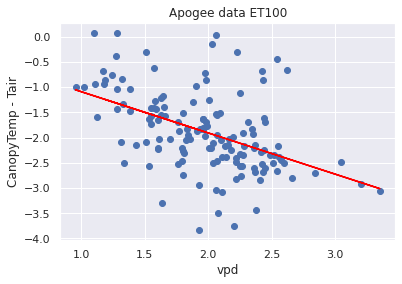

[[-0.81756816]] [-0.27237378]


In [67]:
plt.scatter(x, y)
plt.plot(x, Y_pred, color='red')
plt.title('Apogee data ET100')
plt.ylabel ('CanopyTemp - Tair')
plt.xlabel ('vpd')
plt.show()

### extract slope and interccept
b1= m1.intercept_
a1 = m1.coef_
print(a1,b1)
a1=-0.81756816
b1= -0.27237378

##### i) Compute Upper limit and lower limit using empirical relationship
##### ii) Compute CWSI

In [68]:
ET100_daily['es'] =esat_(ET100_daily['tair'] )

In [69]:
ET100_daily['LL'] = a1 + b1 * ET100_daily ['vpd']
ET100_daily['VPG'] = (ET100_daily['es'] * (a1 + ET100_daily['tair'] )) - ET100_daily['es']  * ET100_daily['tair']

ET100_daily['UL_mod'] =(b1-a1) * abs(ET100_daily['VPG'])

ET100_daily['UL'] =ET100_daily['CanopyTemp'] + 5

ET100_daily['diff'] = ET100_daily['CanopyTemp'] - ET75_daily['tair']

ET100_daily['CWSI'] = abs((ET100_daily['diff'] - ET100_daily['LL'])/(ET100_daily['UL_mod'] - ET100_daily['LL']))

ET100_daily


,local_time,tair,tbelow,CanopyTemp,ref_tbelow,ndvi_x,evi,Sapflow(mm/day),Dt,Dr,...,kc,ea,date,es,LL,VPG,UL_mod,UL,diff,CWSI
0,2021-05-05,23.980931,23.195586,20.139635,22.770941,0.421319,0.124792,1.109223,1.811980,0.695710,...,0.917274,1.288431,2021-05-05,2.979735,-1.343731,-2.436137,1.328168,25.139635,-4.039460,1.008919
1,2021-05-06,23.501041,22.903316,20.553303,23.619285,0.422080,0.123458,1.169568,1.338715,0.385545,...,0.911456,1.082500,2021-05-06,2.894936,-1.341761,-2.366808,1.290370,25.553303,-3.041980,0.645948
2,2021-05-07,20.155639,20.111932,18.009283,21.071681,0.428871,0.126330,1.140808,0.931280,0.367424,...,0.914570,0.983502,2021-05-07,2.360149,-1.208520,-1.929583,1.051998,23.009283,-2.110835,0.399163
3,2021-05-08,19.614818,19.277538,17.118071,20.175208,0.419073,0.125391,0.968285,0.991119,0.225720,...,0.910776,1.056470,2021-05-08,2.282357,-1.182636,-1.865982,1.017323,22.118071,-2.579218,0.634822
4,2021-05-09,20.525166,20.203110,17.958582,21.083581,0.420325,0.125470,1.007788,1.113593,0.444712,...,0.903909,1.014258,2021-05-09,2.414626,-1.236154,-1.974121,1.076280,22.958582,-2.692787,0.629913
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134,2021-09-16,22.850555,21.739506,22.538182,24.817627,0.333850,0.071582,0.276665,0.731083,0.232180,...,0.770237,1.453035,2021-09-16,2.783363,-1.229214,-2.275589,1.240638,27.538182,-0.414515,0.329857
135,2021-09-17,21.916375,21.566596,21.526018,23.898437,0.340455,0.072073,0.260159,0.514470,-0.122750,...,0.746140,1.503814,2021-09-17,2.629708,-1.165317,-2.149966,1.172149,26.526018,-0.591682,0.245409
136,2021-09-18,21.433708,21.385393,21.512297,23.807320,0.315074,0.067426,0.236535,0.624235,0.265915,...,0.746155,1.382039,2021-09-18,2.553264,-1.166648,-2.087468,1.138076,26.512297,0.064183,0.534047
137,2021-09-19,20.788052,20.647608,20.851688,23.190895,0.312905,0.068027,0.195512,0.099418,-0.239845,...,0.768038,1.426267,2021-09-19,2.454048,-1.117853,-2.006351,1.093851,25.851688,0.186312,0.589665


##### Plot CWSI computed from empirical relationship between vpd and temp difference (tair minus CanopyTemp for ET100)

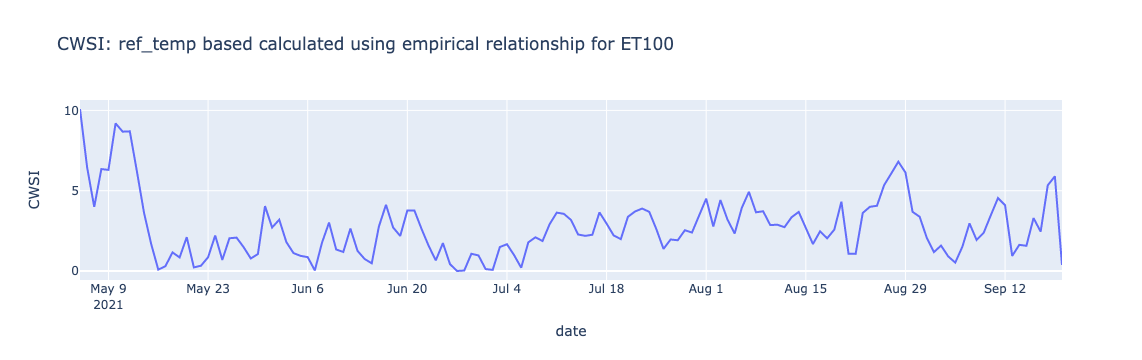

In [358]:
fig = px.line(
    ET100_daily, x="date", y="CWSI",  title="CWSI: ref_temp based calculated using empirical relationship for ET100"
)
fig.show()

#### Checking empirical relationship of vpd and difference in tair and tbelow from Mark

##### 1. ET75

In [70]:
mask_m = (ET75_daily['date'] > '2021-05-01') & (ET75_daily['date'] <= '2021-09-17')
ET75_daily_selected_m = ET75_daily.loc[mask_m]

In [71]:
data_dict1 = {'vpd': ET75_daily_selected_m['vpd'], 'diff':ET75_daily_selected_m['tbelow']-ET75_daily_selected_m['tair']} 
df =pd.DataFrame.from_dict(data_dict1)

In [72]:
x = df.iloc[:,0].values.reshape(-1,1)
y= df.iloc[:,1].values.reshape(-1,1)

In [73]:
### mark data 

m2= lr.fit(x, y)
Y_pred = lr.predict(x)

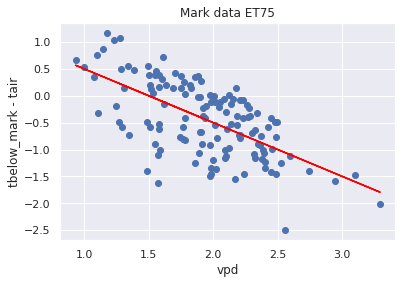

[[-1.00053353]] [1.50208549]


In [74]:
plt.scatter(x, y)
plt.plot(x, Y_pred, color='red')
plt.title('Mark data ET75')
plt.ylabel ('tbelow_mark - tair')
plt.xlabel ('vpd')
plt.show()

### extract slope and interccept
b= m2.intercept_
a = m2.coef_
print(a,b)
a1= -1.00053353
b1= 1.50208549

In [75]:
ET75_daily.columns

Index(['local_time', 'tair', 'tbelow', 'CanopyTemp', 'ref_tbelow', 'ndvi_x',
       'evi', 'Sapflow(mm/day)', 'Dt', 'Dr', 'Gt', 'Gc', 'treatments',
       'device', 'time', 'precip', 'ndvi_y', 'vpd', 'swdw', 'et', 'etc', 'kc',
       'ea', 'date', 'es', 'LL', 'VPG', 'UL_mod', 'UL', 'diff', 'CWSI'],
      dtype='object')

In [76]:
ET75_daily['LL_m'] = a1 + b1 * ET75_daily['vpd']

ET75_daily['UL_m'] =ET75_daily['tbelow'] + 5

ET75_daily['diff_m'] = ET75_daily['tbelow'] - ET75_daily['tair']

ET75_daily['CWSI_mark'] = abs((ET75_daily['diff_m'] - ET75_daily['LL_m'])/(ET75_daily['UL_m'] - ET75_daily['LL_m']))*10

ET75_daily.tail(5)

,local_time,tair,tbelow,CanopyTemp,ref_tbelow,ndvi_x,evi,Sapflow(mm/day),Dt,Dr,...,LL,VPG,UL_mod,UL,diff,CWSI,LL_m,UL_m,diff_m,CWSI_mark
134,2021-09-16,22.952697,21.556936,22.716667,22.992827,0.331167,0.073099,0.660723,0.845668,0.335303,...,-0.038763,-1.871741,2.042875,27.716667,-0.236030,0.094765,1.234532,26.556936,-1.395761,1.038721
135,2021-09-17,22.117699,21.634473,21.662998,22.132833,0.349487,0.075951,0.605223,0.813353,0.243621,...,-0.132528,-1.779211,1.941886,26.662998,-0.454701,0.155308,0.901652,26.634473,-0.483226,0.538176
136,2021-09-18,21.448114,21.536854,21.742856,21.935008,0.314088,0.068649,0.588163,0.812037,0.372507,...,-0.139698,-1.707925,1.864082,26.742856,0.294742,0.216810,0.876195,26.536854,0.088740,0.306873
137,2021-09-19,20.665376,20.958728,21.034735,21.210168,0.311711,0.068524,0.537728,0.645975,0.266414,...,-0.223967,-1.627769,1.776597,26.034735,0.369359,0.296579,0.577027,25.958728,0.293352,0.111763
138,2021-09-20,14.278973,12.134918,12.986460,13.484473,0.324357,0.039876,0.002200,0.097454,-0.017692,...,-0.170828,-1.087337,1.186753,17.986460,-1.292513,0.826237,0.765677,17.134918,-2.144056,1.777561


##### 2.ET100

In [77]:
mask_m = (ET100_daily['date'] > '2021-05-01') & (ET100_daily['date'] <= '2021-09-17')
ET100_daily_selected= ET100_daily.loc[mask_m]

In [78]:
data_dict100_m = {'vpd': ET100_daily_selected['vpd'], 'diff':ET100_daily_selected['tbelow']- ET100_daily_selected['tair']} 
df100_m =pd.DataFrame.from_dict(data_dict100_m)

In [79]:
x= df100_m.iloc[:,0].values.reshape(-1,1)
y= df100_m.iloc[:,1].values.reshape(-1,1)

In [80]:
m3= lr.fit(x, y)
Y_pred = lr.predict(x)

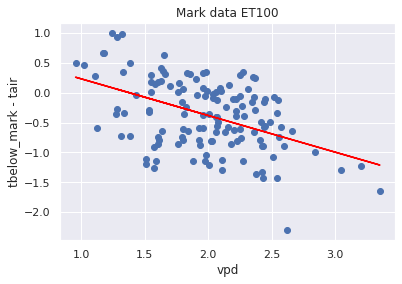

[[-0.6146723]] [0.84836232]


In [81]:
plt.scatter(x, y)
plt.plot(x, Y_pred, color='red')
plt.title('Mark data ET100')
plt.ylabel ('tbelow_mark - tair')
plt.xlabel ('vpd')
plt.show()


### extract slope and interccept
b= m3.intercept_
a = m3.coef_
print(a,b)
a2= -0.6146723
b2= 0.84836232

In [82]:
ET100_daily['LL_m'] = a1 + b1 * ET100_daily['vpd']

ET100_daily['UL_m'] =ET100_daily['tbelow'] + 5

ET100_daily['diff_m'] = ET100_daily['tbelow'] - ET100_daily['tair']

ET100_daily['CWSI_mark'] = abs((ET100_daily['diff_m'] - ET100_daily['LL_m'])/(ET100_daily['UL_m'] - ET100_daily['LL_m']))*10

ET75_daily.tail(5)

,local_time,tair,tbelow,CanopyTemp,ref_tbelow,ndvi_x,evi,Sapflow(mm/day),Dt,Dr,...,LL,VPG,UL_mod,UL,diff,CWSI,LL_m,UL_m,diff_m,CWSI_mark
134,2021-09-16,22.952697,21.556936,22.716667,22.992827,0.331167,0.073099,0.660723,0.845668,0.335303,...,-0.038763,-1.871741,2.042875,27.716667,-0.236030,0.094765,1.234532,26.556936,-1.395761,1.038721
135,2021-09-17,22.117699,21.634473,21.662998,22.132833,0.349487,0.075951,0.605223,0.813353,0.243621,...,-0.132528,-1.779211,1.941886,26.662998,-0.454701,0.155308,0.901652,26.634473,-0.483226,0.538176
136,2021-09-18,21.448114,21.536854,21.742856,21.935008,0.314088,0.068649,0.588163,0.812037,0.372507,...,-0.139698,-1.707925,1.864082,26.742856,0.294742,0.216810,0.876195,26.536854,0.088740,0.306873
137,2021-09-19,20.665376,20.958728,21.034735,21.210168,0.311711,0.068524,0.537728,0.645975,0.266414,...,-0.223967,-1.627769,1.776597,26.034735,0.369359,0.296579,0.577027,25.958728,0.293352,0.111763
138,2021-09-20,14.278973,12.134918,12.986460,13.484473,0.324357,0.039876,0.002200,0.097454,-0.017692,...,-0.170828,-1.087337,1.186753,17.986460,-1.292513,0.826237,0.765677,17.134918,-2.144056,1.777561


#### one dataframe for both treatments 

In [83]:
cwsi_both= ET75_daily.append(ET100_daily)

In [84]:
cwsi_both.treatments.unique()
cwsi_both = cwsi_both[cwsi_both['CWSI'].between(0, 1)]

#### CWSI for both treatments calculated using empirical relationship and CanopyTemp

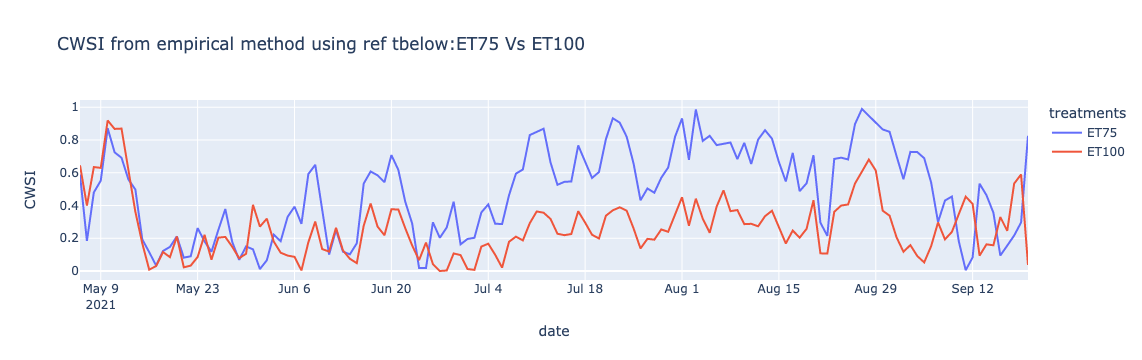

In [85]:
fig = px.line(
    cwsi_both, x="date", y="CWSI", color='treatments',  title="CWSI from empirical method using ref tbelow:ET75 Vs ET100 "
)
fig.show()

#### 1. CWSI using energy balance approach ( aerodynamic resistance and metereological factors)
#### Function to calculate the upper limit and lower limit 

In [86]:
import math

#### calculate upper limit

In [87]:
def upper_limit(df):
    cp = 1013 # heat capacity of air
    d = 1.225 #density of air
    zm = 4.5 # height of wind measurement 
    chmax = 4
    dp = 2*(chmax/3)
    zom = 0.123 * chmax
    zoh = 0.1 * zom 
    ra=(math.log((zm-dp)/zom)*math.log((zm-dp)/zoh))/(0.41*0.41*2)
    #ra=14.16
    print (ra)
    ul_m = (ra * (df["swdw"]))/( cp * d )
    return ul_m



In [88]:
ET100_daily['ul_m']=upper_limit(ET100_daily)
ET75_daily['ul_m']=upper_limit(ET75_daily)

14.155736460482046
14.155736460482046


In [89]:
ET100_daily.head(5)

,local_time,tair,tbelow,CanopyTemp,ref_tbelow,ndvi_x,evi,Sapflow(mm/day),Dt,Dr,...,VPG,UL_mod,UL,diff,CWSI,LL_m,UL_m,diff_m,CWSI_mark,ul_m
0,2021-05-05,23.980931,23.195586,20.139635,22.770941,0.421319,0.124792,1.109223,1.811980,0.695710,...,-2.436137,1.328168,25.139635,-4.039460,1.008919,1.901147,28.195586,-0.785345,1.021696,0.347895
1,2021-05-06,23.501041,22.903316,20.553303,23.619285,0.422080,0.123458,1.169568,1.338715,0.385545,...,-2.366808,1.290370,25.553303,-3.041980,0.645948,1.890280,27.903316,-0.597725,0.956445,0.341907
2,2021-05-07,20.155639,20.111932,18.009283,21.071681,0.428871,0.126330,1.140808,0.931280,0.367424,...,-1.929583,1.051998,23.009283,-2.110835,0.399163,1.155488,25.111932,-0.043706,0.500573,0.351734
3,2021-05-08,19.614818,19.277538,17.118071,20.175208,0.419073,0.125391,0.968285,0.991119,0.225720,...,-1.865982,1.017323,22.118071,-2.579218,0.634822,1.012739,24.277538,-0.337280,0.580284,0.350826
4,2021-05-09,20.525166,20.203110,17.958582,21.083581,0.420325,0.125470,1.007788,1.113593,0.444712,...,-1.974121,1.076280,22.958582,-2.692787,0.629913,1.307883,25.203110,-0.322055,0.682119,0.343833


In [90]:
## call function to compute upper limit
cwsi_both['ul_m'] = upper_limit(cwsi_both)

14.155736460482046


In [91]:
cwsi_both.head(5)

,local_time,tair,tbelow,CanopyTemp,ref_tbelow,ndvi_x,evi,Sapflow(mm/day),Dt,Dr,...,VPG,UL_mod,UL,diff,CWSI,LL_m,UL_m,diff_m,CWSI_mark,ul_m
1,2021-05-06,23.595283,23.563791,22.549796,NaN,0.404210,0.126446,1.039320,NaN,NaN,...,-1.945786,2.123690,27.549796,-1.045487,0.589159,1.831688,28.563791,-0.031492,0.696982,0.348623
2,2021-05-07,20.120117,20.591776,19.709352,NaN,0.416702,0.128819,0.974943,NaN,NaN,...,-1.573893,1.717796,24.709352,-0.410765,0.183523,1.085649,25.591776,0.471659,0.250546,0.358879
3,2021-05-08,19.697290,19.843792,18.722800,NaN,0.412625,0.127460,0.910791,NaN,NaN,...,-1.533194,1.673376,23.722800,-0.974490,0.480042,0.961491,24.843792,0.146502,0.341252,0.357146
4,2021-05-09,20.651369,20.781492,19.628708,NaN,0.408159,0.126626,0.952281,NaN,NaN,...,-1.626365,1.775065,24.628708,-1.022661,0.551970,1.274062,25.781492,0.130123,0.466772,0.351821
5,2021-05-10,21.765346,21.618488,20.139309,NaN,0.406944,0.127497,0.624831,NaN,NaN,...,-1.741381,1.900597,25.139309,-1.626037,0.871753,1.430592,26.618488,-0.146858,0.626273,0.356941


##### calculate lower limit

In [92]:
def lower_limit(df): 
    chmax = 4
    dp = 2*(chmax/3)
    zom = 0.123 * chmax
    zoh = 0.1 * zom
    print(zoh)
    gamma =  101.325 *(101.3*(((293-0.0065 *36.6)/293)** 5.26))/ (0.622 * (2503 -2.39 * df.tair)* 100)
    #print (gamma)
    delta = (4098 * (0.6108 * np.exp((17.27 * df.tair) / (df.tair + 237.3)) / ((df.tair + 237.3) ** 2)))
    #print (delta)
    es =0.6108 *(np.exp((17.27*df.tair)/(df.tair+237.3)))
    ea = df['ea']
    ll_m = ((df.ul_m * gamma)/delta + zoh) - ((es - ea) / (delta + zoh)) 
    return ll_m

In [93]:
cwsi_both['ll_m'] = lower_limit (cwsi_both)

0.0492


In [94]:
cwsi_both[['treatments','ul_m', 'll_m']]

,treatments,ul_m,ll_m
1,ET75,0.348623,-7.735100
2,ET75,0.358879,-6.598024
3,ET75,0.357146,-6.011132
4,ET75,0.351821,-6.665464
5,ET75,0.356941,-6.721704
...,...,...,...
134,ET100,0.266644,-5.956734
135,ET100,0.244579,-5.223172
136,ET100,0.258240,-5.541918
137,ET100,0.264373,-4.970449


#### Compute CWSI using energy balance for both treatments

In [95]:
## adding a column for difference in Tair and Tcanopy from ref_tbelow
cwsi_both['diff'] = cwsi_both['CanopyTemp'] - cwsi_both['tair'] 

##adding a column for difference in Tair and Tcanopy from mark_tbelow
cwsi_both['diff_mark'] = cwsi_both['tbelow'] - cwsi_both['tair'] 

## CWSI from ref_tbelow
cwsi_both['cwsi_met'] = (cwsi_both['diff'] - cwsi_both['ll_m'])/(cwsi_both['ul_m'] - cwsi_both['ll_m']) 

## CWSI from mark_tbelow
cwsi_both['cwsi_met_mark'] = (cwsi_both['diff_mark'] - cwsi_both['ll_m'])/(cwsi_both['ul_m'] - cwsi_both['ll_m'] )
#cwsi_both['cwsi_met_new'] = np.log((cwsi_both['CanopyTemp'] - cwsi_both['ll_m'])/(cwsi_both['ul_m'] - cwsi_both['ll_m']))

## truncate to range
cwsi_both = cwsi_both[cwsi_both['cwsi_met'].between(0.4,1)]

cwsi_both = cwsi_both[cwsi_both['cwsi_met_mark'].between(0.4,1)]

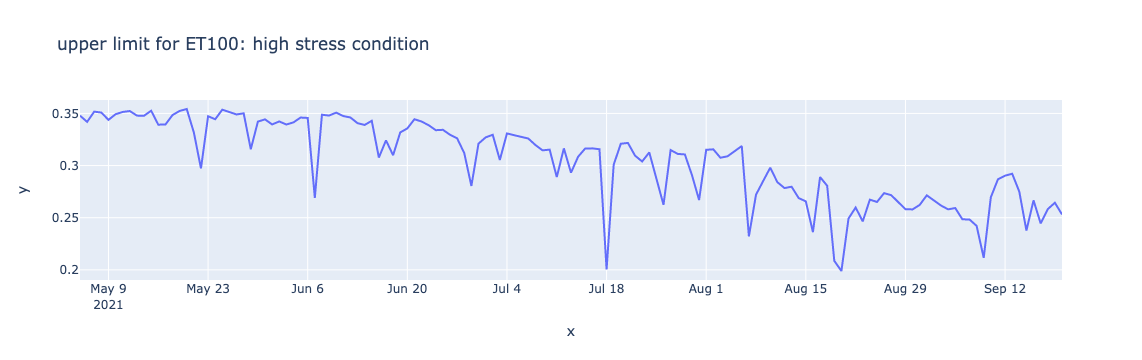

In [96]:
#### check upper limit for ET100

fig = px.line(
     x=ET100_daily["local_time"], y=ET100_daily.ul_m,  title="upper limit for ET100: high stress condition"
)
fig.show()

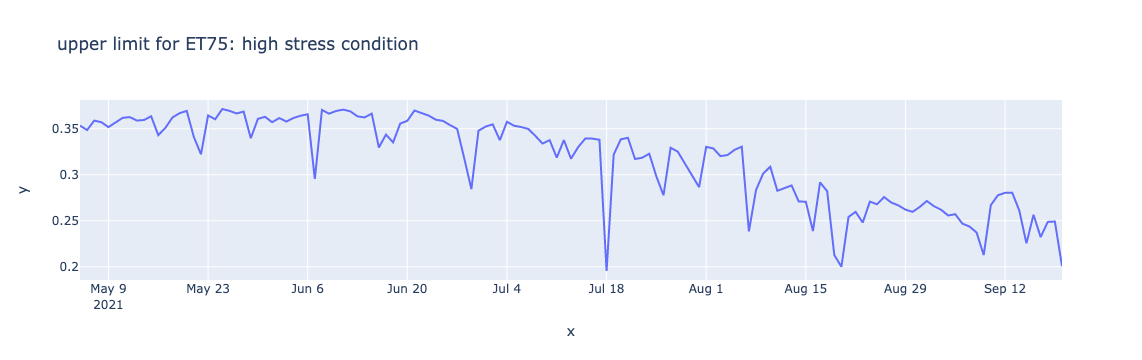

In [97]:
# Check upper limit for ET75

fig = px.line(
     x=ET75_daily["local_time"], y=ET75_daily.ul_m,  title="upper limit for ET75: high stress condition"
)
fig.show()

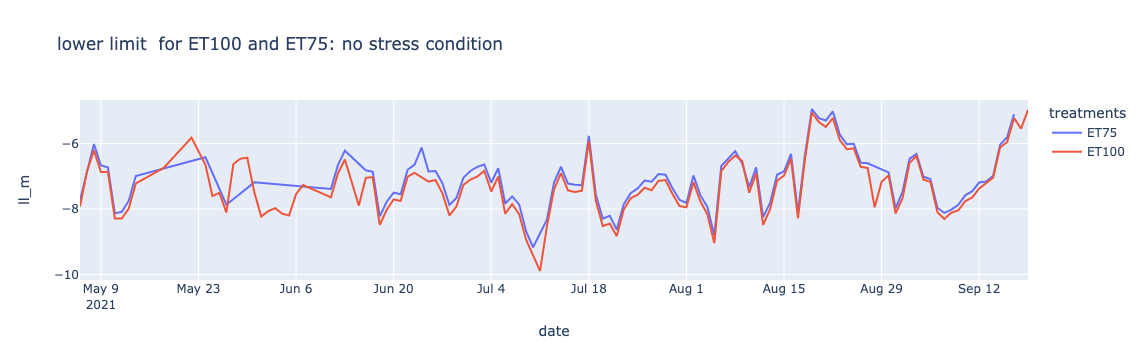

In [98]:
## Check lower limit for both treatments
fig = px.line(
    cwsi_both, x="date", y="ll_m", color='treatments',  title="lower limit  for ET100 and ET75: no stress condition"
)
fig.show()

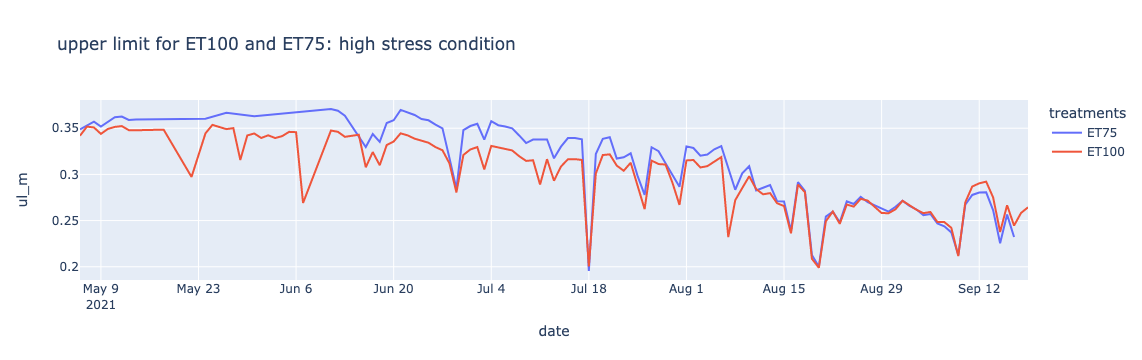

In [99]:
## Check upper limit for both treatments
fig = px.line(
    cwsi_both, x="date", y="ul_m", color='treatments',  title="upper limit for ET100 and ET75: high stress condition"
)
fig.show()

#### Plotting CWSI for both treatments calculated using energy balance ( aerodynamic resistance and ref_ tbelow)

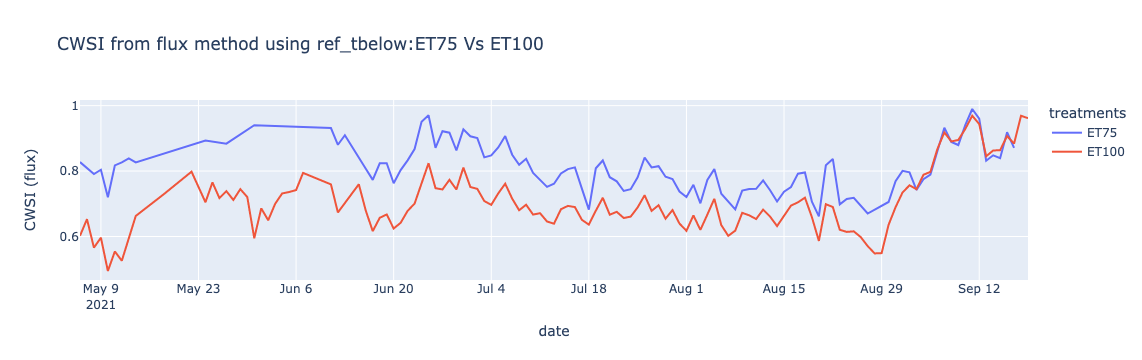

In [100]:
fig = px.line(
    cwsi_both, x="date", y="cwsi_met", color='treatments',  title="CWSI from flux method using ref_tbelow:ET75 Vs ET100"
)
fig.update_layout( yaxis = {'title': "CWSI (flux)"})
fig.show()

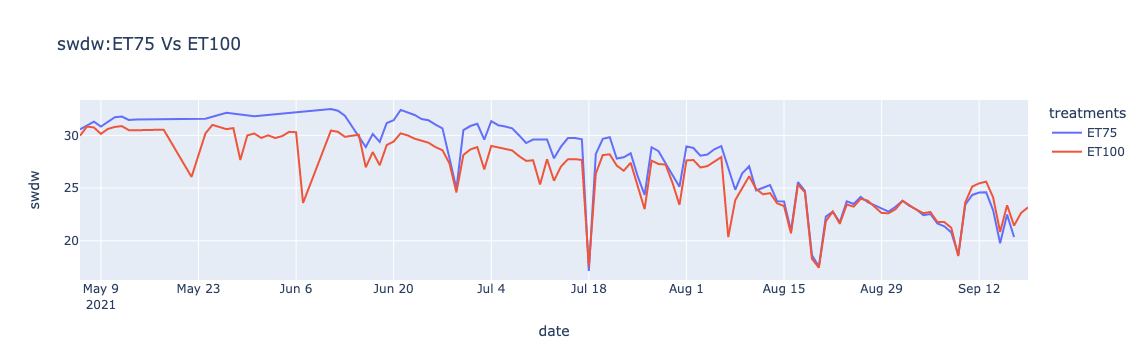

In [127]:
## check swdw
fig = px.line(
    cwsi_both, x="date", y="swdw", color='treatments',  title="swdw:ET75 Vs ET100"
)
fig.show()

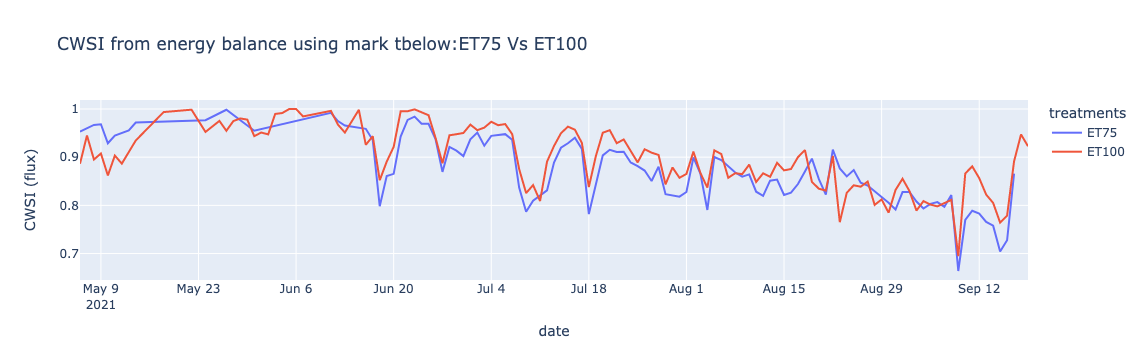

In [128]:
fig = px.line(
    cwsi_both, x="date", y="cwsi_met_mark", color='treatments',  title="CWSI from energy balance using mark tbelow:ET75 Vs ET100"
)

fig.update_layout( yaxis = {'title': "CWSI (flux)"})
fig.show()

In [101]:
# import plotly.graph_objects as go
# from plotly.subplots import make_subplots

cwsi_both_copy = cwsi_both.groupby('treatments')
cwsi_both_copy

##### plot rainfall data

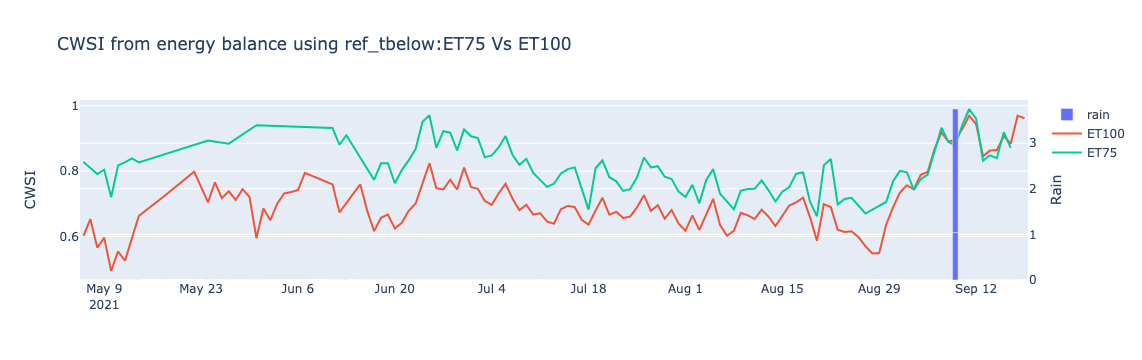

In [102]:
#cwsi_both = cwsi_both.groupby('treatments')

data= [go.Bar(
    x=cwsi_both['date'],
    y=cwsi_both['precip'],
    name="rain",
    yaxis='y2',
  
)] + [
    go.Scatter(
    x=site_data['date'],
    y=site_data['cwsi_met'],
   
    name= site_name

)
for site_name, site_data in cwsi_both_copy]
fig =go.FigureWidget(data=data)
fig.update_layout(yaxis={'title': 'CWSI'}, 
                  yaxis2={'title': 'Rain', 'overlaying':'y', 'side':'right'}, 
                  title= "CWSI from energy balance using ref_tbelow:ET75 Vs ET100 ")
    
fig.show()

##### The next step here is to test the new mark tbelow from a new model ( from Hong`s work). 
##### The new tbelow is used to compute CWSI from energy balance approach

#### New tbelow test for CWSI

In [103]:
## Read parquet file from Hong ( s3 bucket)
dev_test = pd.read_parquet(
    's3://arable-adse-dev/Carbon Project/Stress Index/UCD_Almond/combined_almond_prediction.parquet.gzip'
)

In [104]:
dev_test.columns

Index(['tbelow_pred', 'time', 'device', 'lw_temp_2', 'lw_temp_3', 'b1dw',
       'b1uw', 'b4dw', 'b4uw', 'b6dw', 'b6uw', 'swuw', 'swdw', 'lwdw', 'lwuw',
       'tair', 'tbelow', 'lat', 'long', 'CanopyTemp', 'ndvi', 'evi',
       'ndvi_gt08', 'Kt', 'Kd'],
      dtype='object')

In [105]:
dev_test.head(5)

,tbelow_pred,time,device,lw_temp_2,lw_temp_3,b1dw,b1uw,b4dw,b4uw,b6dw,...,tair,tbelow,lat,long,CanopyTemp,ndvi,evi,ndvi_gt08,Kt,Kd
0,14.720448,2021-05-05 07:00:00+00:00,C006743,17.01,17.76,0.002924,0.003030,0.002610,0.002401,0.003912,...,18.554678,17.760000,36.59985,-119.51541,15.15,0.196772,0.002955,0.0,1.0,1.0
1,14.677070,2021-05-05 07:05:00+00:00,C006743,16.97,17.60,0.003001,0.003030,0.002292,0.002464,0.004079,...,18.808270,14.301009,36.59985,-119.51541,15.22,0.160004,0.002358,0.0,1.0,1.0
2,14.704950,2021-05-05 07:10:00+00:00,C006743,16.84,17.66,0.002770,0.003194,0.002292,0.002591,0.003495,...,18.697550,14.624764,36.59985,-119.51541,15.32,0.171735,0.002699,0.0,1.0,1.0
3,14.495997,2021-05-05 07:15:00+00:00,C006743,16.72,17.67,0.002847,0.002948,0.002037,0.002148,0.003661,...,18.776958,14.364658,36.59985,-119.51541,15.24,0.302836,0.004691,0.0,1.0,1.0
4,14.954134,2021-05-05 07:20:00+00:00,C006743,16.62,17.62,0.003232,0.002948,0.002165,0.001896,0.003578,...,18.331224,14.674231,36.59985,-119.51541,15.40,0.318195,0.004455,0.0,1.0,1.0


In [106]:
dev_test=dev_test[['time', 'device','tbelow_pred']]

In [107]:
dev_test['treatments'] =dev_test['device'].map({'C006743' :'ET100', 'C006727': 'ET75' })

In [108]:
dev_test.head()

,time,device,tbelow_pred,treatments
0,2021-05-05 07:00:00+00:00,C006743,14.720448,ET100
1,2021-05-05 07:05:00+00:00,C006743,14.677070,ET100
2,2021-05-05 07:10:00+00:00,C006743,14.704950,ET100
3,2021-05-05 07:15:00+00:00,C006743,14.495997,ET100
4,2021-05-05 07:20:00+00:00,C006743,14.954134,ET100


In [109]:
dev_test['local_time'] = pd.to_datetime(dev_test['time'].dt.date)


In [110]:
dev_test=dev_test.groupby(['treatments', 'local_time']).mean().reset_index()

In [111]:
dev_test

,treatments,local_time,tbelow_pred
0,ET75,2021-05-05,21.660559
1,ET75,2021-05-06,23.092714
2,ET75,2021-05-07,21.609472
3,ET75,2021-05-08,19.459408
4,ET75,2021-05-09,20.328077
...,...,...,...
273,ET100,2021-09-16,21.650579
274,ET100,2021-09-17,21.544235
275,ET100,2021-09-18,20.918104
276,ET100,2021-09-19,20.617872


In [112]:
### Dataframe from old tbelow analysis ( from above)
cwsi_both.columns 

Index(['local_time', 'tair', 'tbelow', 'CanopyTemp', 'ref_tbelow', 'ndvi_x',
       'evi', 'Sapflow(mm/day)', 'Dt', 'Dr', 'Gt', 'Gc', 'treatments',
       'device', 'time', 'precip', 'ndvi_y', 'vpd', 'swdw', 'et', 'etc', 'kc',
       'ea', 'date', 'es', 'LL', 'VPG', 'UL_mod', 'UL', 'diff', 'CWSI', 'LL_m',
       'UL_m', 'diff_m', 'CWSI_mark', 'ul_m', 'll_m', 'diff_mark', 'cwsi_met',
       'cwsi_met_mark'],
      dtype='object')

In [113]:
cwsi_both

,local_time,tair,tbelow,CanopyTemp,ref_tbelow,ndvi_x,evi,Sapflow(mm/day),Dt,Dr,...,CWSI,LL_m,UL_m,diff_m,CWSI_mark,ul_m,ll_m,diff_mark,cwsi_met,cwsi_met_mark
1,2021-05-06,23.595283,23.563791,22.549796,NaN,0.404210,0.126446,1.039320,NaN,NaN,...,0.589159,1.831688,28.563791,-0.031492,0.696982,0.348623,-7.735100,-0.031492,0.827541,0.952978
3,2021-05-08,19.697290,19.843792,18.722800,NaN,0.412625,0.127460,0.910791,NaN,NaN,...,0.480042,0.961491,24.843792,0.146502,0.341252,0.357146,-6.011132,0.146502,0.790895,0.966923
4,2021-05-09,20.651369,20.781492,19.628708,NaN,0.408159,0.126626,0.952281,NaN,NaN,...,0.551970,1.274062,25.781492,0.130123,0.466772,0.351821,-6.665464,0.130123,0.804129,0.968407
5,2021-05-10,21.765346,21.618488,20.139309,NaN,0.406944,0.127497,0.624831,NaN,NaN,...,0.871753,1.430592,26.618488,-0.146858,0.626273,0.356941,-6.721704,-0.146858,0.719865,0.928828
6,2021-05-11,23.548482,23.441925,22.358228,NaN,0.405714,0.128975,NaN,NaN,NaN,...,0.724808,2.081603,28.441925,-0.106557,0.830096,0.361907,-8.133181,-0.106557,0.817287,0.944855
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,2021-09-15,23.734875,22.474576,23.108250,25.374875,0.350423,0.071009,0.294537,0.747869,0.158571,...,0.157176,1.365415,27.474576,-1.260299,1.005668,0.237692,-6.114607,-1.260299,0.863936,0.764181
134,2021-09-16,22.850555,21.739506,22.538182,24.817627,0.333850,0.071582,0.276665,0.731083,0.232180,...,0.329857,1.269610,26.739506,-1.111050,0.934695,0.266644,-5.956734,-1.111050,0.906961,0.778626
135,2021-09-17,21.916375,21.566596,21.526018,23.898437,0.340455,0.072073,0.260159,0.514470,-0.122750,...,0.245409,0.917230,26.566596,-0.349779,0.493973,0.244579,-5.223172,-0.349779,0.883876,0.891297
136,2021-09-18,21.433708,21.385393,21.512297,23.807320,0.315074,0.067426,0.236535,0.624235,0.265915,...,0.534047,0.924572,26.385393,-0.048315,0.382111,0.258240,-5.541918,-0.048315,0.969027,0.947147


In [114]:
### merge hong`s df and df created from old tbelow
new_df = pd.merge(dev_test, cwsi_both, on=['treatments', 'local_time'], how= 'left' )

In [115]:
new_df =new_df.dropna()

In [117]:
new_df.to_csv('s3://arable-adse-dev/Carbon Project/Stress Index/UCD_Almond/combine_cwsi_and_M2_tbelow.csv')

In [118]:
new_df.columns

Index(['treatments', 'local_time', 'tbelow_pred', 'tair', 'tbelow',
       'CanopyTemp', 'ref_tbelow', 'ndvi_x', 'evi', 'Sapflow(mm/day)', 'Dt',
       'Dr', 'Gt', 'Gc', 'device', 'time', 'precip', 'ndvi_y', 'vpd', 'swdw',
       'et', 'etc', 'kc', 'ea', 'date', 'es', 'LL', 'VPG', 'UL_mod', 'UL',
       'diff', 'CWSI', 'LL_m', 'UL_m', 'diff_m', 'CWSI_mark', 'ul_m', 'll_m',
       'diff_mark', 'cwsi_met', 'cwsi_met_mark'],
      dtype='object')

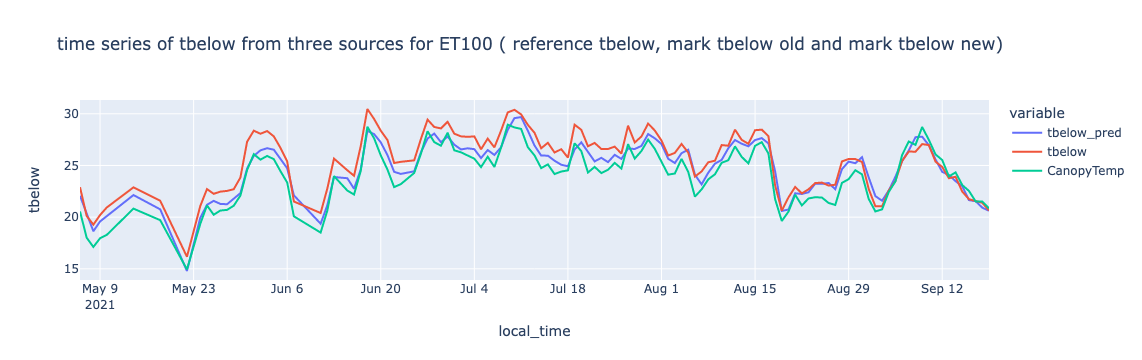

In [119]:
fig = px.line(
    new_df.loc[new_df['treatments'] =='ET100'], x="local_time", y=['tbelow_pred', 'tbelow' ,  'CanopyTemp'], 
    title="time series of tbelow from three sources for ET100 ( reference tbelow, mark tbelow old and mark tbelow new)"
)
fig.update_layout(yaxis={'title': 'tbelow'}) 

fig.show()

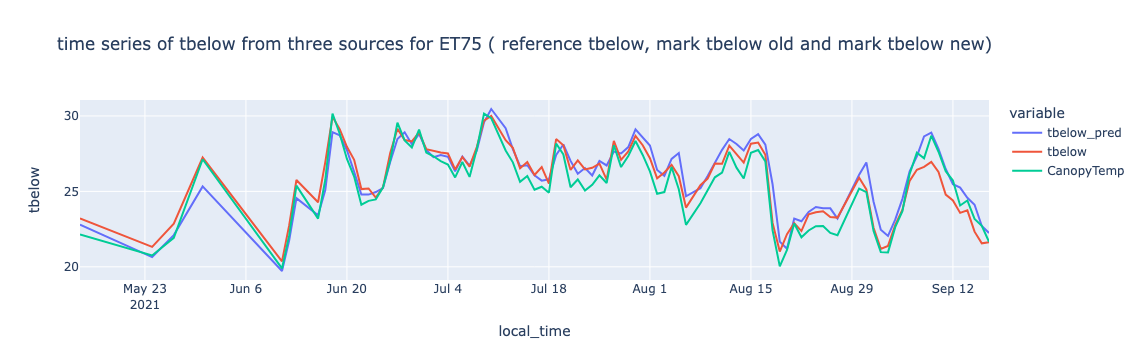

In [146]:
fig = px.line(
    new_df.loc[new_df['treatments'] =='ET75'], x="local_time", y=['tbelow_pred', 'tbelow' ,  'CanopyTemp'], 
    title="time series of tbelow from three sources for ET75 ( reference tbelow, mark tbelow old and mark tbelow new)"
)
fig.update_layout(yaxis={'title': 'tbelow'}) 

fig.show()

#### Compute CWSI using energy balance for both treatments for new tbelow ( hong`s data)

In [120]:
new_df['diff_mark_new'] = new_df['tbelow_pred'] - new_df['tair']
new_df['cwsi_mark_new'] = (new_df['diff_mark_new'] - new_df['ll_m'])/(new_df['ul_m'] - new_df['ll_m'] )

new_df = new_df[new_df['cwsi_mark_new'].between(0,1)]

In [122]:
# new_df

In [124]:
# new_df.columns

##### Plotting CWSI for new tbelow mark fom energy balance method

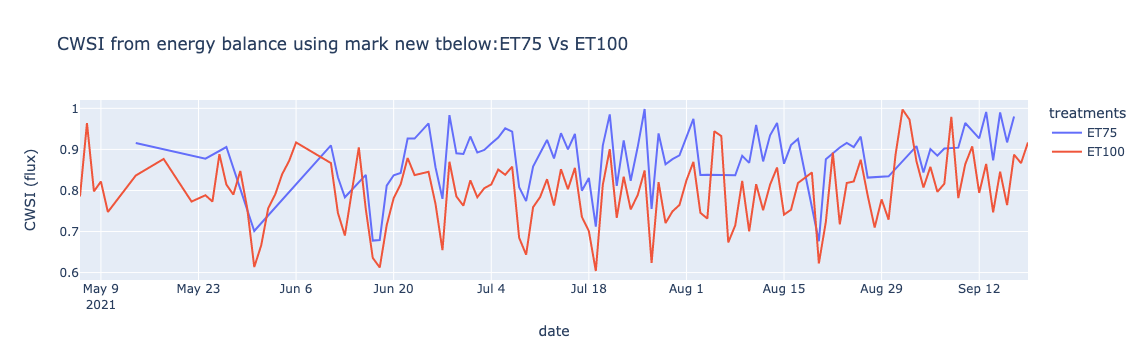

In [150]:

fig = px.line(
    new_df, x="date", y="cwsi_mark_new", color='treatments',  title="CWSI from energy balance using mark new tbelow:ET75 Vs ET100"
)
fig.update_layout( yaxis = {'title': "CWSI (flux)"})
fig.show()

### check tair minus tbelow from three sources 
        diff: differnce between tair and ref_tbelow
        diff_mark: differnce between tair and mark_tbelow(old)
        diff_mark_new: difference between tair and mark_tbelow (new)

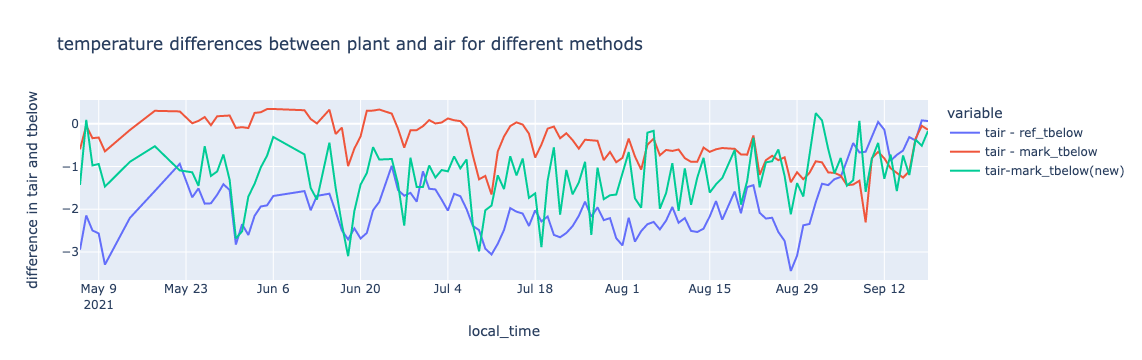

In [125]:
fig = px.line(
    new_df.loc[new_df['treatments'] =='ET100'], x="local_time", y=['diff', 'diff_mark' ,  'diff_mark_new'],  title="temperature differences between plant and air for different methods"
)
fig.update_layout(yaxis={'title': 'difference in tair and tbelow'},
                 legend = dict())
newnames = {'diff' : "tair - ref_tbelow",'diff_mark' : 'tair - mark_tbelow', 'diff_mark_new': 'tair-mark_tbelow(new)' }
fig.for_each_trace(lambda t: t.update(name = newnames[t.name]))
                                      #legendgroup = newnames[t.name],
                                      #hovertemplate = t.hovertemplate.replace(t.name, newnames[t.name])
                                     
                  
fig.show()

##### the differnce computed from new tbelow is improved and is closer to the values computed from the ref tbelow. 
##### Howeverthe early season (around June 6) where the crops at ET75 were supposed to have maximum stress, 
##### the difference from new tbelow did not correspond well with the difference from reference tbelow

#### Check the relationship of CWSI with other direct measurements of crop water stress
    i. Sapflow
    ii. stomatal conductance
    iii. Dendrometer reading

In [126]:
new_df.columns

Index(['treatments', 'local_time', 'tbelow_pred', 'tair', 'tbelow',
       'CanopyTemp', 'ref_tbelow', 'ndvi_x', 'evi', 'Sapflow(mm/day)', 'Dt',
       'Dr', 'Gt', 'Gc', 'device', 'time', 'precip', 'ndvi_y', 'vpd', 'swdw',
       'et', 'etc', 'kc', 'ea', 'date', 'es', 'LL', 'VPG', 'UL_mod', 'UL',
       'diff', 'CWSI', 'LL_m', 'UL_m', 'diff_m', 'CWSI_mark', 'ul_m', 'll_m',
       'diff_mark', 'cwsi_met', 'cwsi_met_mark', 'diff_mark_new',
       'cwsi_mark_new'],
      dtype='object')

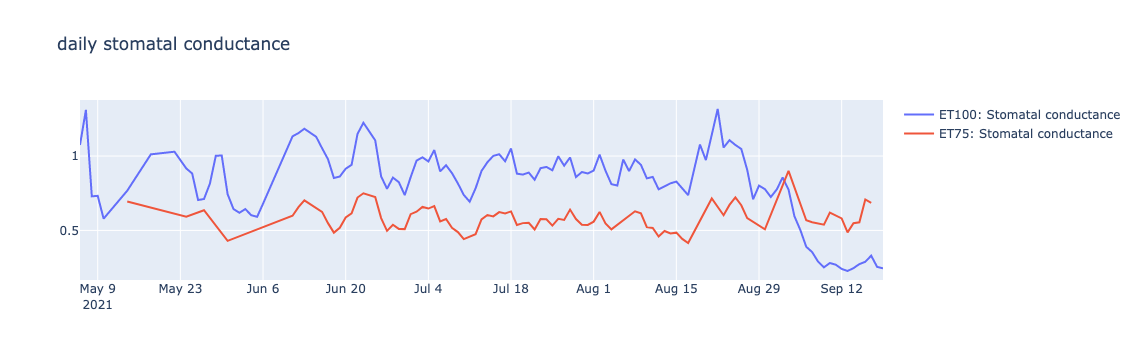

In [127]:
df_plot_100 =new_df[new_df['treatments']== 'ET100']
df_plot_75 = new_df[new_df['treatments']== 'ET75']
figure = go.FigureWidget(
    data=[
        go.Scatter(
            x=df_plot_100["local_time"],
            y=df_plot_100["Gt"],
            name="ET100: Stomatal conductance ",
        ),
        go.Scatter(
            x=df_plot_75["local_time"],
            y=df_plot_75["Gt"],
            name="ET75: Stomatal conductance",
            
        ),
    ]
   
)
figure.update_layout(title = 'daily stomatal conductance' )
figure.show()


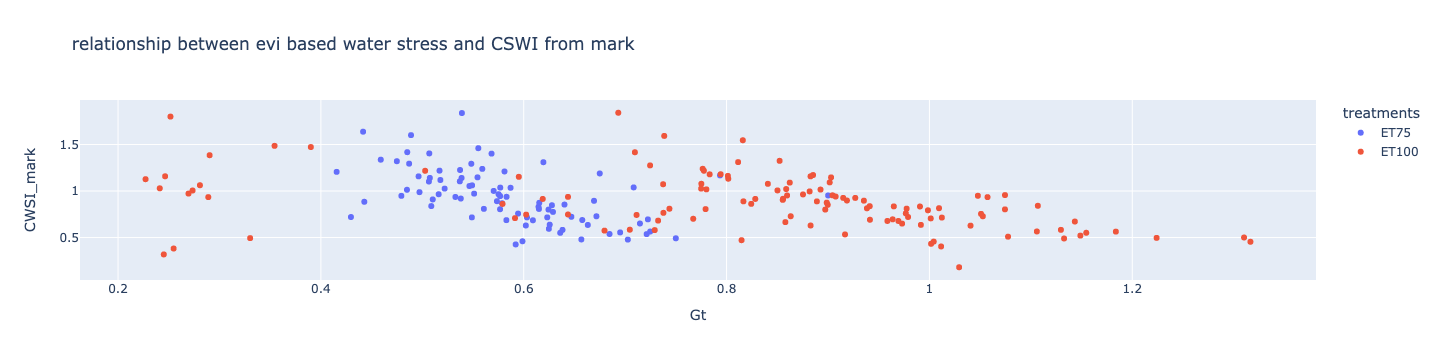

In [128]:
fig = px.scatter(
    new_df, x = 'Gt', y= "CWSI_mark", color = 'treatments', title="relationship between evi based water stress and CSWI from mark"
)

fig.show()

In [129]:
new_df_subset = new_df.loc[(new_df['local_time'] >  '2021-06-15') & ( new_df['local_time'] <  '2021-08-30')]

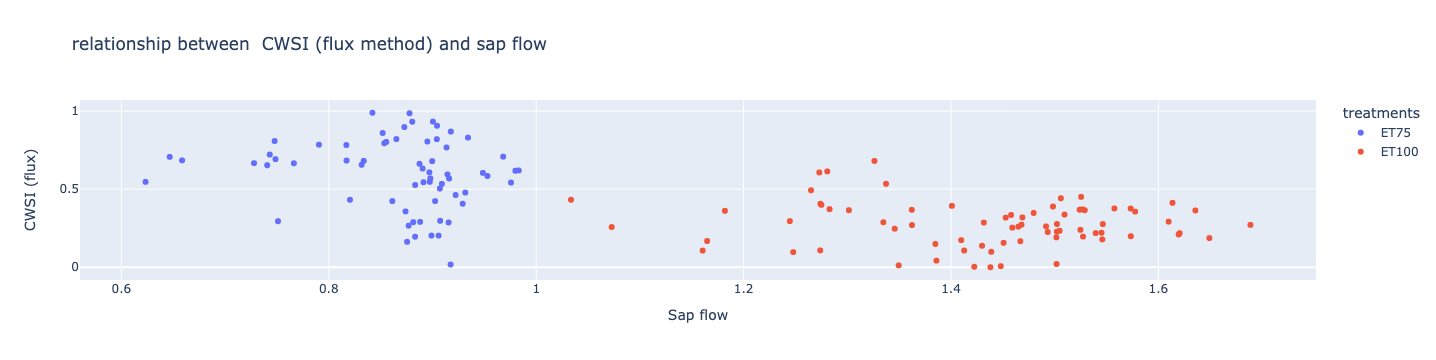

In [130]:
fig = px.scatter(
    new_df_subset, x = 'Sapflow(mm/day)', y= "CWSI", color = 'treatments', title="relationship between  CWSI (flux method) and sap flow"
)

fig.update_layout(yaxis={'title': 'CWSI (flux)'}, xaxis={'title': 'Sap flow'}) 
fig.show()

In [133]:
# new_df.to_csv('s3://arable-adse-dev/Carbon Project/Stress Index/UCD_Almond/cwsi_mark.csv')
# new_df_subset.to_csv('s3://arable-adse-dev/Carbon Project/Stress Index/UCD_Almond/cwsi_mark_subset.csv')

In [ ]:
fig = px.scatter(
    new_df_subset, x = 'Sapflow(mm/day)', y= "CWSI", color = 'treatments', title="relationship between  CWSI (flux method) and sap flow"
)

fig.update_layout(yaxis={'title': 'CWSI (flux)'}, xaxis={'title': 'Sap flow'}) 
fig.show()

In [132]:
new_df_subset

,treatments,local_time,tbelow_pred,tair,tbelow,CanopyTemp,ref_tbelow,ndvi_x,evi,Sapflow(mm/day),...,UL_m,diff_m,CWSI_mark,ul_m,ll_m,diff_mark,cwsi_met,cwsi_met_mark,diff_mark_new,cwsi_mark_new
42,ET75,2021-06-16,23.414253,24.243763,24.279047,23.195597,23.999263,0.393823,0.113682,0.909075,...,29.279047,0.035284,0.594071,0.329634,-6.816844,0.035284,0.807206,0.958812,-0.829510,0.837802
43,ET75,2021-06-17,25.083969,27.060908,26.939752,25.769536,26.605623,0.398391,0.116393,0.897012,...,31.939752,-0.121156,0.716638,0.343666,-6.862786,-0.121156,0.773115,0.935499,-1.976938,0.677982
44,ET75,2021-06-18,28.924677,31.333178,29.940621,30.160681,30.618787,0.384013,0.110197,0.953010,...,34.940621,-1.392557,1.417602,0.335188,-8.224640,-1.392557,0.823865,0.798157,-2.408501,0.679469
45,ET75,2021-06-19,28.721317,29.898116,29.123386,28.821883,29.438660,0.386461,0.117007,0.975727,...,34.123386,-0.774730,1.118671,0.355683,-7.778149,-0.774730,0.823956,0.861023,-1.176799,0.811592
46,ET75,2021-06-20,27.731081,28.652602,27.954038,27.146972,27.842365,0.385586,0.117869,0.968164,...,32.954038,-0.698564,1.034996,0.358647,-7.496917,-0.698564,0.762681,0.865419,-0.921521,0.837037
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,ET100,2021-08-25,23.220760,24.097255,23.347151,21.898672,24.006656,0.332146,0.074344,1.274037,...,28.347151,-0.750103,0.802979,0.265130,-6.147651,-0.750103,0.615812,0.841686,-0.876494,0.821977
252,ET100,2021-08-26,23.306763,23.908128,23.055029,21.375542,23.762360,0.326475,0.074970,1.337343,...,28.055029,-0.853099,0.949098,0.273573,-6.712082,-0.853099,0.598297,0.838716,-0.601365,0.874752
253,ET100,2021-08-27,22.704226,23.921173,23.136349,21.180960,23.548771,0.329632,0.075323,1.273002,...,28.136349,-0.784824,0.940740,0.271625,-6.743966,-0.784824,0.570694,0.849414,-1.216947,0.787819
254,ET100,2021-08-28,24.644382,26.762520,25.393022,23.317131,25.495821,0.327901,0.073631,1.326198,...,30.393022,-1.369499,1.416757,0.265347,-7.948403,-1.369499,0.548229,0.800962,-2.118138,0.709818
